# Titanic dataset exploration and survival prediction

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import preprocessing, grid_search, metrics, linear_model, neighbors, svm, ensemble

/Users/davidzerah/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/davidzerah/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Reading data

In [2]:
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')

In [3]:
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
print(data_train.info())
print(data_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null 

## Analyzing dataset features

The dataset has features that identifies a passenger, these features (PassengerId, Name, Ticket) do not influence the output result. So we can remove them from dataset

In [5]:
# save PassengerId from test dataset to put in the results later
pass_ids = data_test[['PassengerId']]
# remove PassengerId field that unique for every passenger
data_train = data_train.drop(['PassengerId', 'Name', 'Ticket'], axis=1)
data_test = data_test.drop(['PassengerId', 'Name', 'Ticket'], axis=1)

The dataset has two numerical features (Age and Fare), the rest are categorial features. Let's analyze each feature and it's impact on the result value (Survival).

### Survived (data label)

In [6]:
data_train.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

### Pclass (passenger class)

In [7]:
# as class is categorical feature we can make its type as string
data_train['Pclass'] = data_train['Pclass'].astype(str)

In [8]:
# possible class values
print(data_train['Pclass'].value_counts().sort_index())

1    216
2    184
3    491
Name: Pclass, dtype: int64


[<matplotlib.text.Text at 0x115859e10>, <matplotlib.text.Text at 0x115859a58>]

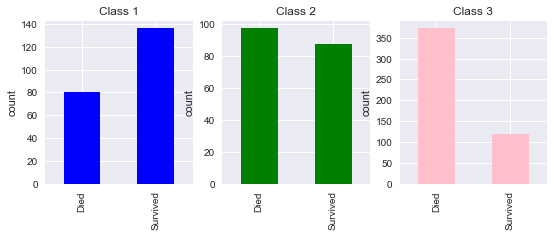

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9, 3))

subplt = data_train[data_train.Pclass=='1']['Survived'].value_counts().sort_index().plot(kind='bar', ax=axes[0], color='blue')
subplt.set_title('Class 1')
subplt.set_ylabel('count')
subplt.set_xticklabels(['Died', 'Survived'])

subplt = data_train[data_train.Pclass=='2']['Survived'].value_counts().sort_index().plot(kind='bar', ax=axes[1], color='green')
subplt.set_title('Class 2')
subplt.set_ylabel('count')
subplt.set_xticklabels(['Died', 'Survived'])

subplt = data_train[data_train.Pclass=='3']['Survived'].value_counts().sort_index().plot(kind='bar', ax=axes[2], color='pink')
subplt.set_title('Class 3')
subplt.set_ylabel('count')
subplt.set_xticklabels(['Died', 'Survived'])

We can see that there's a survival dependency on the passenger class. Passengers of higher class had a higher chance of survival.

### Sex

[<matplotlib.text.Text at 0x11808be10>, <matplotlib.text.Text at 0x11808bda0>]

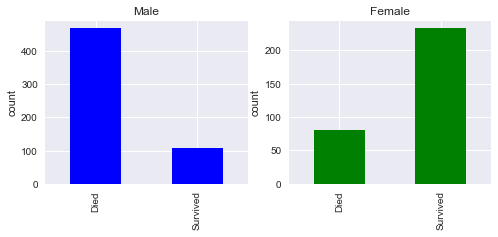

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))

subplt = data_train[data_train.Sex=='male']['Survived'].value_counts().sort_index().plot(kind='bar', ax=axes[0], color='blue')
subplt.set_title('Male')
subplt.set_ylabel('count')
subplt.set_xticklabels(['Died', 'Survived'])

subplt = data_train[data_train.Sex=='female']['Survived'].value_counts().sort_index().plot(kind='bar', ax=axes[1], color='green')
subplt.set_title('Female')
subplt.set_ylabel('count')
subplt.set_xticklabels(['Died', 'Survived'])

Females had a much bigger chance of survival

### Age

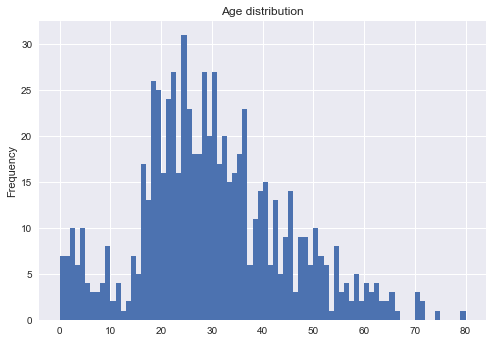

In [11]:
axis = data_train['Age'].dropna().astype(int).plot(kind='hist', bins=80)
axis.set_title('Age distribution')

Let's fill NaN age with random values (normally distributed with mean and standard deviation of the known age distribution) 

In [12]:
# train data
mean_age = data_train['Age'].mean()
std_age = data_train['Age'].std()
print('Mean: {}, standard deviation: {}'.format(mean_age, std_age))
tofillwith = np.floor(np.random.normal(mean_age, std_age, data_train['Age'].isnull().sum()))
tofillwith[tofillwith < 0] = 0 # random value can be negative
data_train['Age'][pd.isnull(data_train["Age"])] = tofillwith

Mean: 29.69911764705882, standard deviation: 14.526497332334044


/Users/davidzerah/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


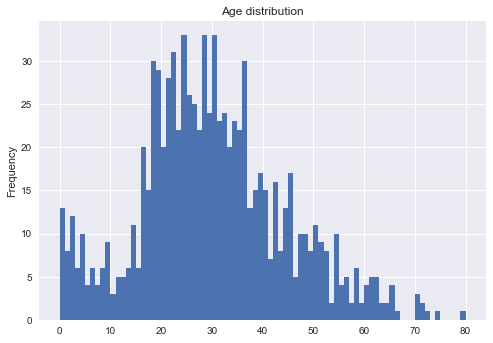

In [13]:
# check new distribution
axis = data_train['Age'].astype(int).plot(kind='hist', bins=80)
axis.set_title('Age distribution')

In [14]:
# test data
mean_age = data_test['Age'].mean()
std_age = data_test['Age'].std()
print('Mean: {}, standard deviation: {}'.format(mean_age, std_age))
tofillwith = np.floor(np.random.normal(mean_age, std_age, data_test['Age'].isnull().sum()))
tofillwith[tofillwith < 0] = 0 # random value can be negative
data_test['Age'][pd.isnull(data_test["Age"])] = tofillwith

Mean: 30.272590361445783, standard deviation: 14.18120923562442


/Users/davidzerah/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


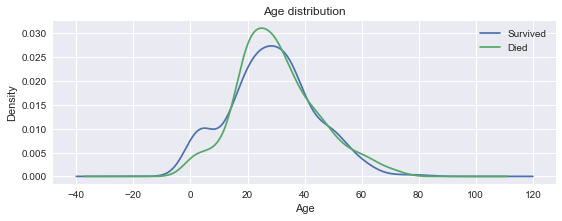

In [15]:
plt.figure(figsize=(9,3))
data_train[data_train.Survived==1]['Age'].plot(kind='density', label='Survived')
data_train[data_train.Survived==0]['Age'].plot(kind='density', label='Died')
plt.xlabel('Age')
plt.legend()
plt.title('Age distribution')

### SibSp

In [16]:
data_train.SibSp.value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

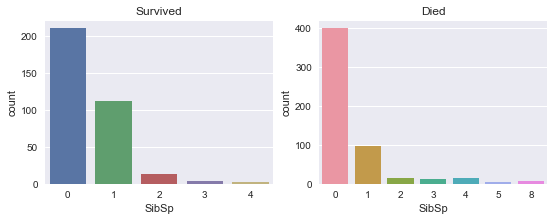

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 3))
ax1= sns.countplot(x='SibSp', data=data_train[data_train.Survived==1], ax=axes[0])
ax2 = sns.countplot(x='SibSp', data=data_train[data_train.Survived==0], ax=axes[1])
ax1.set_title('Survived')
ax2.set_title('Died')

### Parch

In [18]:
data_train.Parch.value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

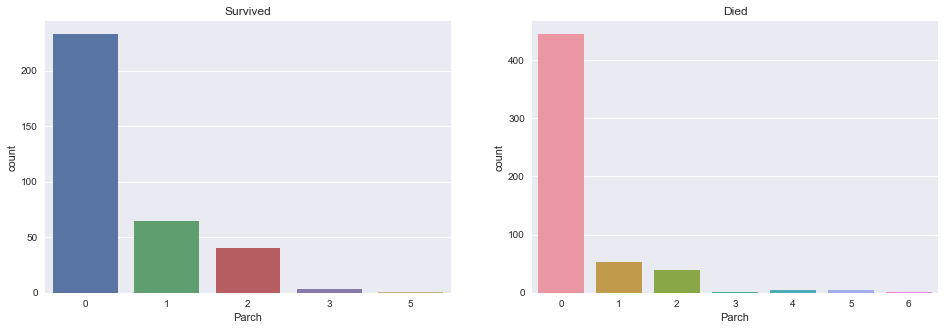

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
ax1= sns.countplot(x='Parch', data=data_train[data_train.Survived==1], ax=axes[0])
ax2 = sns.countplot(x='Parch', data=data_train[data_train.Survived==0], ax=axes[1])
ax1.set_title('Survived')
ax2.set_title('Died')

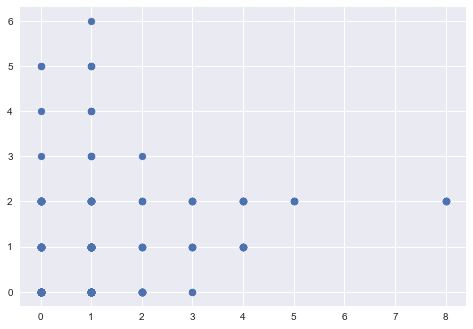

In [20]:
# Check dependency of SibSp and Parch features
plt.scatter(data_train['SibSp'], data_train['Parch'])

It seems that SibSp and Parch features are quite independent

### Fare

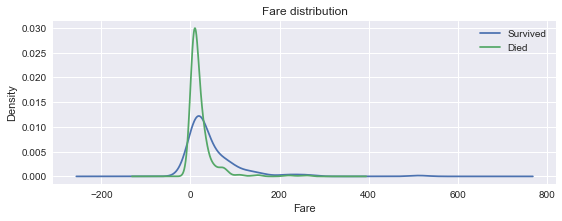

In [21]:
plt.figure(figsize=(9,3))
data_train[data_train.Survived==1]['Fare'].plot(kind='density', label='Survived')
data_train[data_train.Survived==0]['Fare'].plot(kind='density', label='Died')
plt.xlabel('Fare')
plt.legend()
plt.title('Fare distribution')

[<matplotlib.text.Text at 0x119059898>, <matplotlib.text.Text at 0x119062358>]

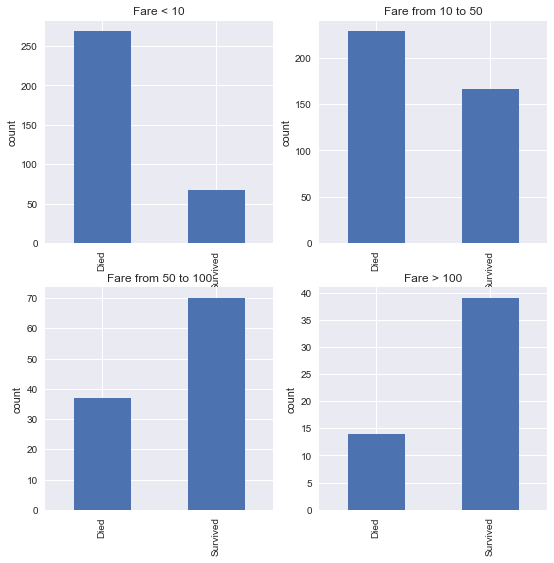

In [22]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 9))

subplt = data_train[data_train.Fare<=10.]['Survived'].value_counts().sort_index().plot(kind='bar', ax=axes[0, 0])
subplt.set_title('Fare < 10')
subplt.set_ylabel('count')
subplt.set_xticklabels(['Died', 'Survived'])

subplt = data_train[(data_train.Fare>10.0) & (data_train.Fare<=50.0)]['Survived'].value_counts().sort_index().plot(kind='bar', ax=axes[0, 1])
subplt.set_title('Fare from 10 to 50')
subplt.set_ylabel('count')
subplt.set_xticklabels(['Died', 'Survived'])

subplt = data_train[(data_train.Fare>50.0) & (data_train.Fare<=100.0)]['Survived'].value_counts().sort_index().plot(kind='bar', ax=axes[1, 0])
subplt.set_title('Fare from 50 to 100')
subplt.set_ylabel('count')
subplt.set_xticklabels(['Died', 'Survived'])

subplt = data_train[data_train.Fare>100.0]['Survived'].value_counts().sort_index().plot(kind='bar', ax=axes[1, 1])
subplt.set_title('Fare > 100')
subplt.set_ylabel('count')
subplt.set_xticklabels(['Died', 'Survived'])

People with low fare had less chances of survival

We have one NaN value in test data so we can set it to mean (from both train and test datasets)

In [23]:
mean_fare = (data_train['Fare'].sum() + data_test['Fare'].sum()) / (data_train['Fare'].count() + data_test['Fare'].count())
data_test['Fare'] = data_test['Fare'].fillna(mean_fare)

### Cabin

In [24]:
print(data_train.Cabin.isnull().sum())

687


We can remove this column as about querter of objects have NaN values, so it has no influence on result.

In [25]:
data_train.drop(['Cabin'], axis=1, inplace=True)
data_test.drop(['Cabin'], axis=1, inplace=True)

### Embarked

In [26]:
data_train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

[<matplotlib.text.Text at 0x1193b0978>, <matplotlib.text.Text at 0x11934e0b8>]

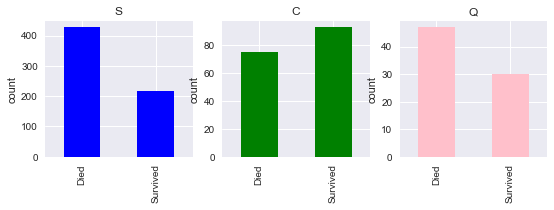

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9, 2.5))

subplt = data_train[data_train.Embarked=='S']['Survived'].value_counts().sort_index().plot(kind='bar', ax=axes[0], color='blue')
subplt.set_title('S')
subplt.set_ylabel('count')
subplt.set_xticklabels(['Died', 'Survived'])

subplt = data_train[data_train.Embarked=='C']['Survived'].value_counts().sort_index().plot(kind='bar', ax=axes[1], color='green')
subplt.set_title('C')
subplt.set_ylabel('count')
subplt.set_xticklabels(['Died', 'Survived'])

subplt = data_train[data_train.Embarked=='Q']['Survived'].value_counts().sort_index().plot(kind='bar', ax=axes[2], color='pink')
subplt.set_title('Q')
subplt.set_ylabel('count')
subplt.set_xticklabels(['Died', 'Survived'])

There are only two NaN values, so leave them as it is. Later they will disappeared after binary encoding 

## Preprocess data

### Binary encoding of categorial features

Let's make binary encoding of categorial features: Sex, Pclass, Embarked

In [28]:
# encode Sex feature
data_train.Sex = np.where(data_train.Sex=='male', 1, 0)
data_test.Sex = np.where(data_test.Sex=='male', 1, 0)

In [29]:
# encode Pclass & Embarked feature
data_train = pd.get_dummies(data=data_train, columns=['Pclass', 'Embarked'])
data_test = pd.get_dummies(data=data_test, columns=['Pclass', 'Embarked'])

In [30]:
print(data_train.info())
print(data_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
Survived      891 non-null int64
Sex           891 non-null int64
Age           891 non-null float64
SibSp         891 non-null int64
Parch         891 non-null int64
Fare          891 non-null float64
Pclass_1      891 non-null uint8
Pclass_2      891 non-null uint8
Pclass_3      891 non-null uint8
Embarked_C    891 non-null uint8
Embarked_Q    891 non-null uint8
Embarked_S    891 non-null uint8
dtypes: float64(2), int64(4), uint8(6)
memory usage: 47.1 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
Sex           418 non-null int64
Age           418 non-null float64
SibSp         418 non-null int64
Parch         418 non-null int64
Fare          418 non-null float64
Pclass_1      418 non-null uint8
Pclass_2      418 non-null uint8
Pclass_3      418 non-null uint8
Embarked_C    418 non-null uint8
Embarked_Q    418 non-n

### Scaling real features

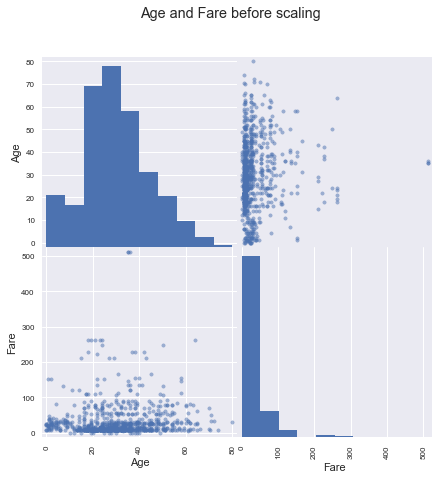

In [31]:
# Check before scaling
pd.tools.plotting.scatter_matrix(data_train[['Age', 'Fare']], alpha=0.5, figsize=(7, 7))
plt.suptitle('Age and Fare before scaling')
plt.show()

We can see that real features, Age and Fare, have different scale.

In [32]:
scaler = preprocessing.StandardScaler()
data_train[['Age', 'Fare']] = scaler.fit_transform(data_train[['Age', 'Fare']])
data_test[['Age', 'Fare']] = scaler.transform(data_test[['Age', 'Fare']])

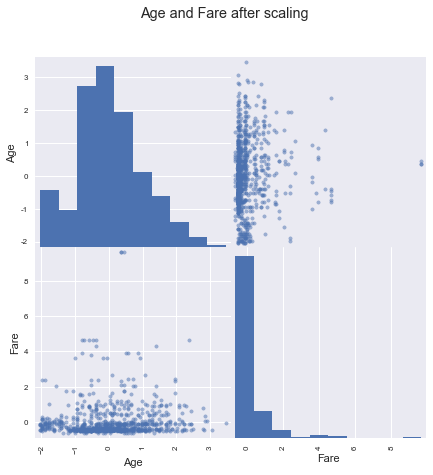

In [33]:
# Check after scaling
pd.tools.plotting.scatter_matrix(data_train[['Age', 'Fare']], alpha=0.5, figsize=(7, 7))
plt.suptitle('Age and Fare after scaling')
plt.show()

## Chosing classifier 

In [34]:
# Extract features (X) and labels (y) from data
X = data_train[data_train.columns[1:]]
y = data_train[data_train.columns[0]]

### Logistic regression

In [35]:
# Finding optimal parameters of the classifier
param_grid = {
              'C': [0.01, 0.05, 0.1, 0.5, 1],
              'penalty': ['l1', 'l2']
             }
estimator = linear_model.LogisticRegression()
lr_gs = grid_search.GridSearchCV(estimator, param_grid, cv=4)
lr_gs.fit(X, y)

GridSearchCV(cv=4, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [36]:
lr_estimator = lr_gs.best_estimator_
print(lr_gs.best_params_)
print(lr_gs.best_score_)

{'C': 0.1, 'penalty': 'l2'}
0.7946127946127947


### K Nearest Neighbors

In [37]:
# Finding optimal parameters of the classifier
param_grid = {
              'n_neighbors': [1, 3, 5, 7, 9, 11, 13],
              'weights': ['uniform', 'distance'],
              'p': [1, 2]
             }
estimator = neighbors.KNeighborsClassifier()
knn_gs = grid_search.GridSearchCV(estimator, param_grid, cv=4)
knn_gs.fit(X, y)

GridSearchCV(cv=4, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13], 'weights': ['uniform', 'distance'], 'p': [1, 2]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [38]:
knn_estimator = knn_gs.best_estimator_
print(knn_gs.best_params_)
print(knn_gs.best_score_)

{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
0.7934904601571269


### Support Vector Machine

In [39]:
# Finding optimal parameters of the classifier
param_grid = {
              'C': [0.5, 1, 2, 4, 10, 20],
              'kernel': ['linear', 'poly', 'rbf'],
             }
estimator = svm.SVC()
svc_gs = grid_search.GridSearchCV(estimator, param_grid, cv=4)
svc_gs.fit(X, y)

GridSearchCV(cv=4, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.5, 1, 2, 4, 10, 20], 'kernel': ['linear', 'poly', 'rbf']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [40]:
svc_estimator = svc_gs.best_estimator_
print(svc_gs.best_params_)
print(svc_gs.best_score_)

{'C': 20, 'kernel': 'poly'}
0.8282828282828283


### Random Forest

In [41]:
# Finding optimal parameters of the classifier
param_grid = {
              'n_estimators': [50, 100, 500],
              'min_samples_leaf': [1, 3, 5]
             }
estimator = ensemble.RandomForestClassifier()
rf_gs = grid_search.GridSearchCV(estimator, param_grid, cv=4)
rf_gs.fit(X, y)

GridSearchCV(cv=4, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [50, 100, 500], 'min_samples_leaf': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [42]:
rf_estimator = rf_gs.best_estimator_
print(rf_gs.best_params_)
print(rf_gs.best_score_)

{'min_samples_leaf': 5, 'n_estimators': 100}
0.813692480359147


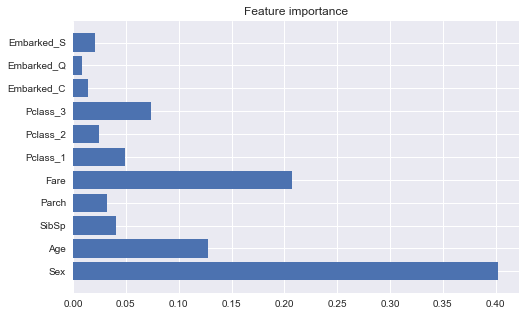

In [43]:
# display feature importance
plt.figure(figsize=(8,5))
plt.barh(np.arange(X.shape[1]), rf_estimator.feature_importances_, align='center')
plt.yticks(np.arange(X.shape[1]), X.columns)
plt.title('Feature importance')

### Comparing models

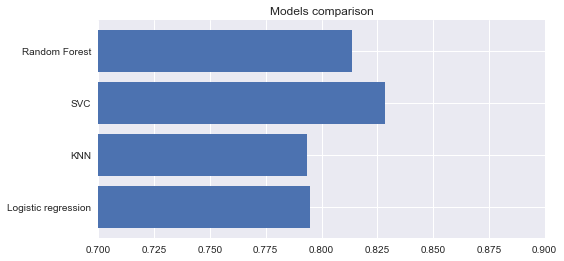

In [44]:
estimators = [lr_gs, knn_gs, svc_gs, rf_gs]
labels = ['Logistic regression', 'KNN', 'SVC', 'Random Forest']

plt.figure(figsize=(8,4))
plt.barh(np.arange(4.), list(map(lambda e: e.best_score_, estimators)), align='center')
plt.yticks(np.arange(4.), labels)
plt.xlim(0.7, 0.9)
plt.title('Models comparison')

The best classifier is SVC with radial kernel, C = 4.

In [45]:
estimator = svc_estimator

## Predict and submit

In [51]:
y_test = estimator.predict(data_test)
#print(pass_ids);
result_df = pd.DataFrame(columns=['PassengerID', 'Survived'])
print(pass_ids);
result_df.PassengerID = pass_ids
#print(result_df)
result_df.Survived = y_test
result_df.head()

     PassengerId
0            892
1            893
2            894
3            895
4            896
5            897
6            898
7            899
8            900
9            901
10           902
11           903
12           904
13           905
14           906
15           907
16           908
17           909
18           910
19           911
20           912
21           913
22           914
23           915
24           916
25           917
26           918
27           919
28           920
29           921
..           ...
388         1280
389         1281
390         1282
391         1283
392         1284
393         1285
394         1286
395         1287
396         1288
397         1289
398         1290
399         1291
400         1292
401         1293
402         1294
403         1295
404         1296
405         1297
406         1298
407         1299
408         1300
409         1301
410         1302
411         1303
412         1304
413         1305
414         13

,PassengerID,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [ ]:
result_df.to_csv('titanic_results.csv', index=False)